In [30]:
# Вначале идет анализ датасета BMW, потом HP
from mplfinance.original_flavor import candlestick_ohlc # pip install --upgrade mplfinance
import yfinance as yf  # pip install yfinance
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import scipy


from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product
from tqdm import tqdm_notebook


In [83]:
df1 = pd.read_csv('/home/violett/Downloads/hometask/BMW.DE.csv', index_col=['Date'], parse_dates=['Date'])
df2 = pd.read_csv('/home/violett/Downloads/hometask/HPQ.csv', index_col=['Date'], parse_dates=['Date'])
df1.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,88.339996,90.269997,87.809998,89.980003,66.076164,774391
2017-01-03,90.500000,91.760002,90.489998,90.830002,66.700356,1514253
2017-01-04,91.019997,91.570000,89.300003,90.180000,66.223030,1224694
2017-01-05,89.500000,90.589996,89.480003,90.339996,66.340523,967699
2017-01-06,90.320000,90.699997,89.809998,90.510002,66.465363,969606


In [3]:
#Посмотрим каждый год подробнее

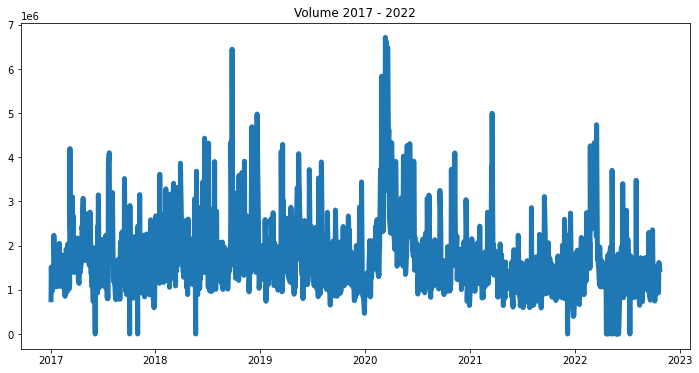

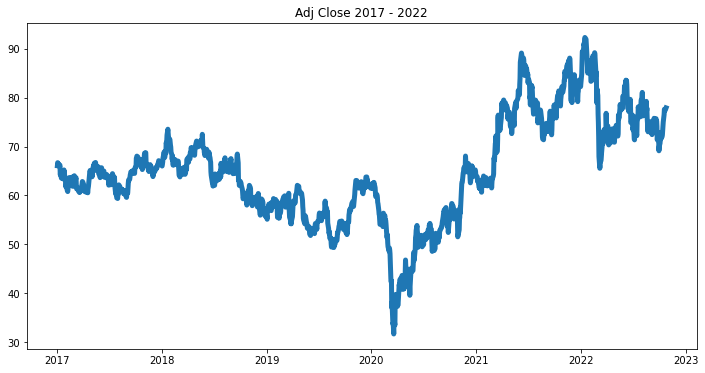

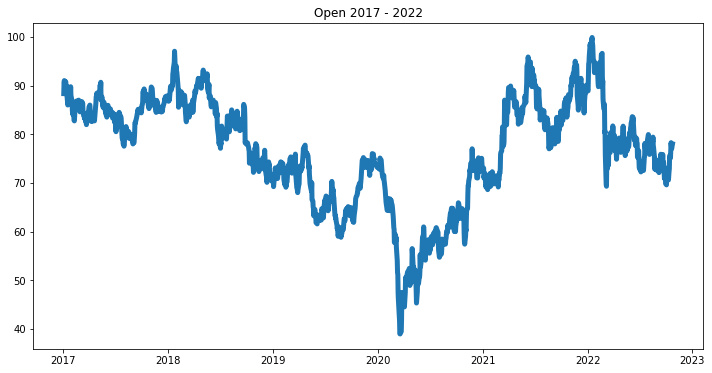

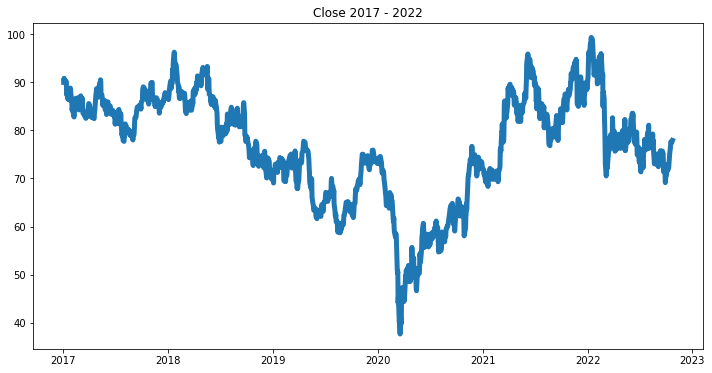

In [4]:
data1 = df1['2017-1-1':'2022-10-24']

plt.figure(figsize=(12, 6))
plt.plot(data1['Volume'],linewidth=5.0)
plt.title('Volume 2017 - 2022')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data1['Adj Close'],linewidth=5.0)
plt.title('Adj Close 2017 - 2022')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data1['Open'],linewidth=5.0)
plt.title('Open 2017 - 2022')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data1['Close'],linewidth=5.0)
plt.title('Close 2017 - 2022')
plt.show()

# Посмотрела статистику по каждому году по графикам. На первый взгляд можно сделать выводы: 
# Тренда нет в Volumeв остальных значениях есть изменяющийся тренд
#. Сезонности нет, если посмотреть графики более подробно, то каждый год экстремумы попадают на разные месяцы
# Возможно если взять выборку по большему количеству можно уловить циклы
# Значение Volume имеет большую дисперсию и аномальные значения по макс и мин
# Поищем в данных тренд, с помомощью сглаживания, с помощью скользящего среднего. Проверим разные окна для сглаживания
# Резкое падение всех показателй вначале 2020 года возможно связано с эпидемией ковид

In [45]:
# Сглаживание среднем
def plotMovingAverage(series, window, plot_intervals=False, scale=1.95, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    # Считаем скользящую среднюю по нашему временному ряду используя тот метод Pandas про который было сказано выше
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Теперь необходимо посчитать доверительные интервалы:
    if plot_intervals:
        # Считаем метрику ошибки например среднюю абсолютную ашибку MAE так как те же единицы измерения что и исходный ряд
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        # Возьмем посчитаем скользящее отклонение, то есть фактически доверительный интервал
        deviation = np.std(series[window:] - rolling_mean[window:])
        # Для нижней границы возьмем наш сглаженный ряд вычтем из него ошибку + стандартное отклонение
        lower_bond = rolling_mean - (mae + scale * deviation)
        # Аналогично для верхней границы только сложим все что посчитали
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            # Просто сравнение на значения верхней и нижней границы чтобы определить является ли наблюдение аномальным:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

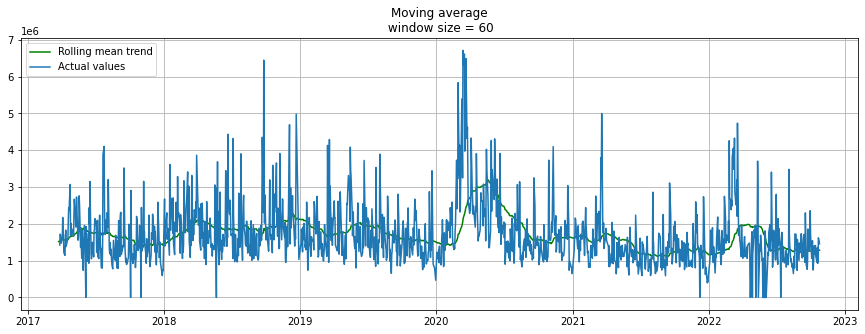

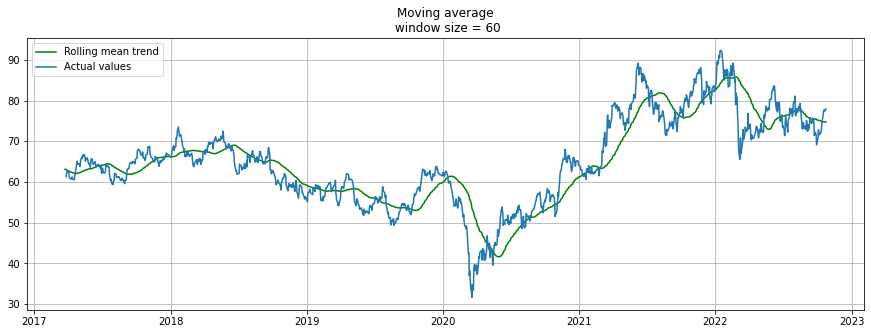

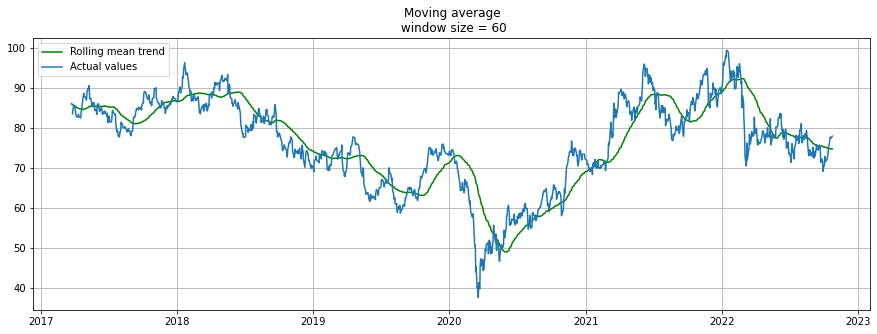

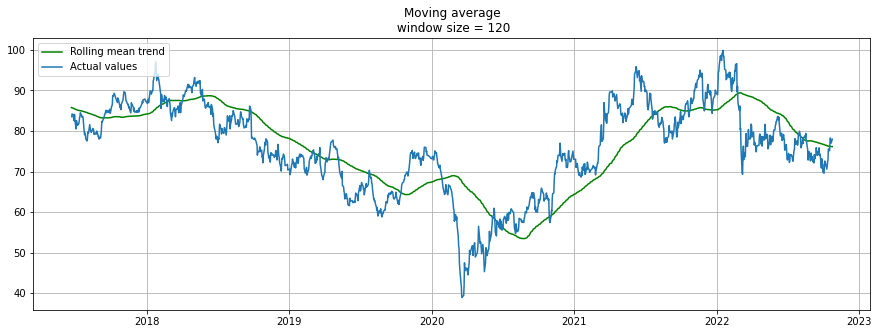

In [57]:
plotMovingAverage(df1['Volume'], 60)
plotMovingAverage(df1['Adj Close'], 60)
plotMovingAverage(df1['Close'], 60)
plotMovingAverage(df1['Open'], 120)
# Во всех параметрах кроме Volume можно уловить тренд: сначала ниспадающий, потом возрастающий
# Проверим есть ли в наших данных сезонность проверив автокорелляцию 

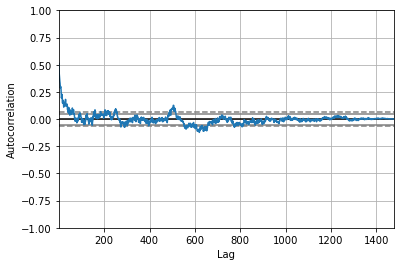

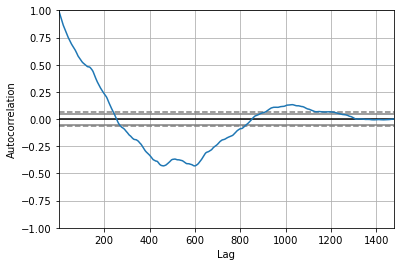

In [60]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df1['Volume'])
plt.show()
autocorrelation_plot(df1['Close'])
plt.show()
# Из графикоф мжем сделать вывод, что в данных Volume нет сезонности, но она есть во всех остальных параметрах
# так как сезонность в данных есть, поищем ее с помощью декомпозиции нашего временного ряда

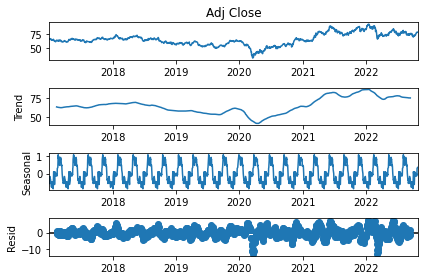

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose
df1_decomposed = seasonal_decompose(df1['Adj Close'].dropna(),model='additive', period=5*12)
plot = df1_decomposed.plot()
    #уровень: Среднее значение в серии.
    #тенденция: Увеличение или уменьшение значения в серии.
    #Сезонность: Повторяющийся краткосрочный цикл в серии.
    #Шум: Случайное изменение в ряду.

In [ ]:
# По полученным данным можно сказать что наши данные не имеют общего тренда, однако они имеют ярко выраженную сезонность

In [ ]:
# Проверим наши данные на стационарность

In [71]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [72]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                -5.882984e+00
p-value                        3.047453e-07
#Lags Used                     1.500000e+01
Number of Observations Used    1.460000e+03
Critical Value (1%)           -3.434837e+00
Critical Value (5%)           -2.863522e+00
Critical Value (10%)          -2.567825e+00
dtype: float64


/home/violett/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


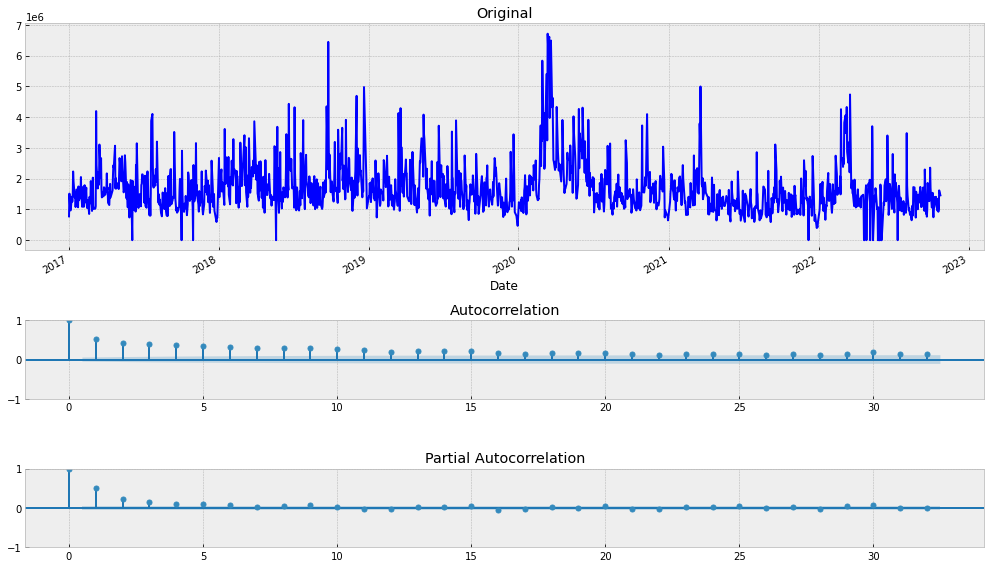

In [24]:
tsplot(df1['Volume'])
#Для значения Volume p-value                        3.047453e-07 - наш ряд стационарен

Results of Dickey-Fuller Test:
Test Statistic                   -1.792918
p-value                           0.383983
#Lags Used                        0.000000
Number of Observations Used    1475.000000
Critical Value (1%)              -3.434791
Critical Value (5%)              -2.863501
Critical Value (10%)             -2.567814
dtype: float64


/home/violett/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


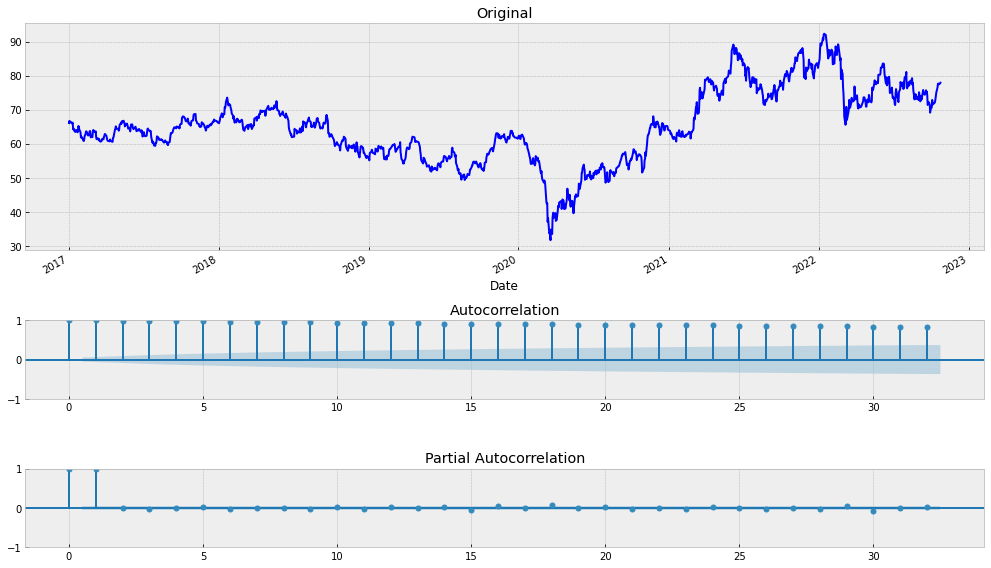

In [74]:
tsplot(df1['Adj Close'])
#Для значения Adj Close p-value                        0.383983 - наш ряд не стационарен Для начала уберем изменение 
#дисперсии при помощи преобразования Бокса-Кокса
#И так как в наших данных присутсвует тренд уберем его дифференцированием
#

In [79]:
series = scipy.stats.boxcox(df1['Close'], 0)
series = series[1:] - series[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.381695e+01
p-value                        8.036049e-26
#Lags Used                     6.000000e+00
Number of Observations Used    1.468000e+03
Critical Value (1%)           -3.434812e+00
Critical Value (5%)           -2.863511e+00
Critical Value (10%)          -2.567819e+00
dtype: float64


/home/violett/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


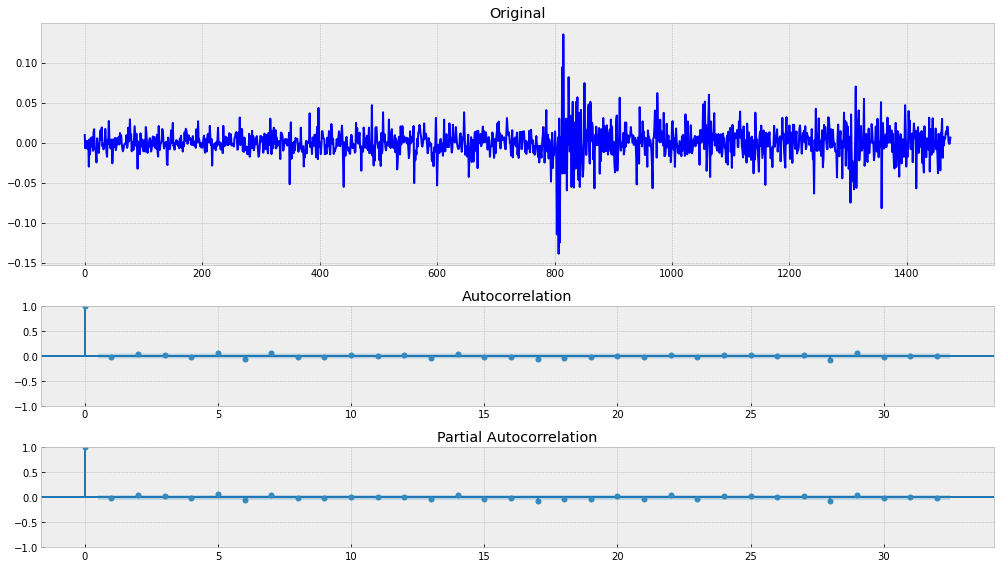

In [80]:
tsplot(series)
# Теперь наш ряд стационарен 

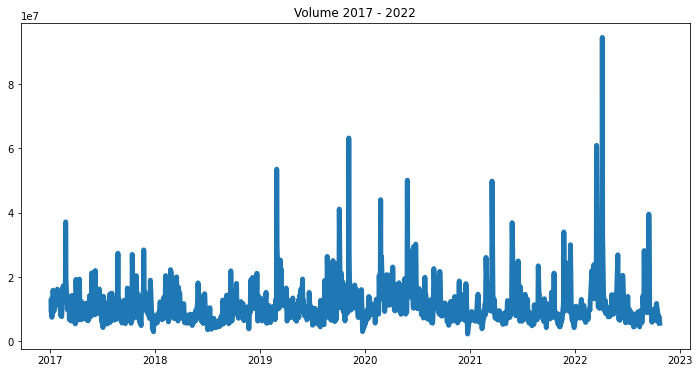

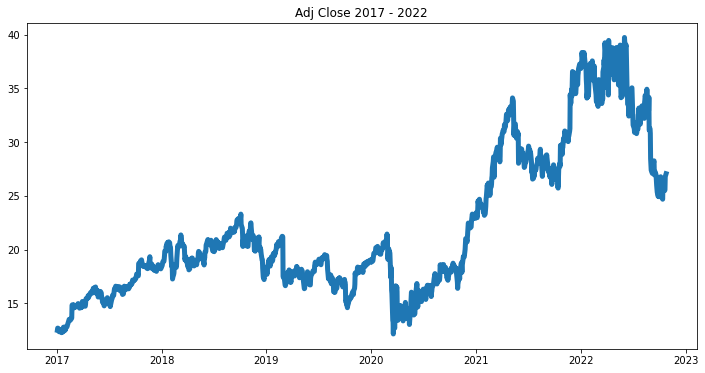

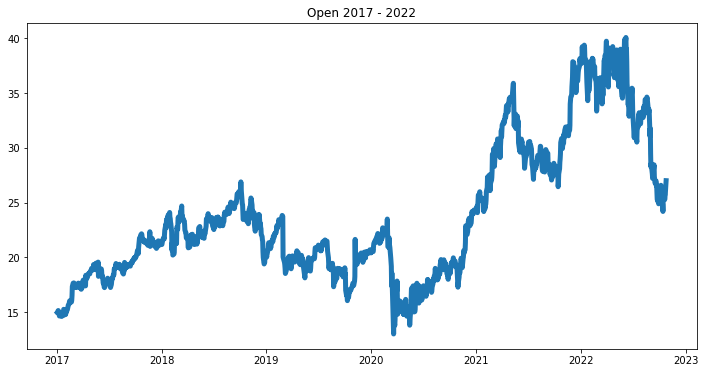

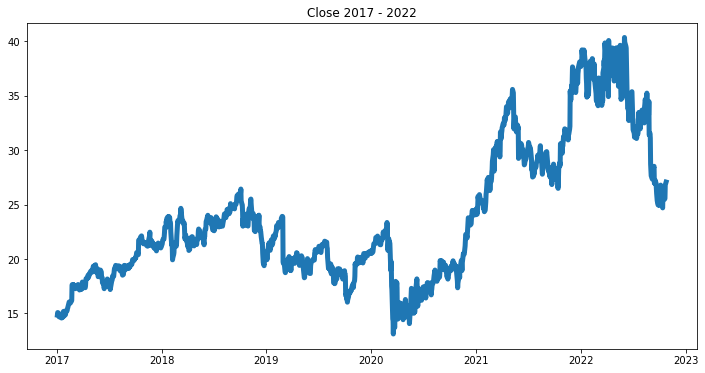

In [84]:
# Посмотрим на данные HP
data1 = df2['2017-1-1':'2022-10-24']

plt.figure(figsize=(12, 6))
plt.plot(data1['Volume'],linewidth=5.0)
plt.title('Volume 2017 - 2022')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data1['Adj Close'],linewidth=5.0)
plt.title('Adj Close 2017 - 2022')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data1['Open'],linewidth=5.0)
plt.title('Open 2017 - 2022')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data1['Close'],linewidth=5.0)
plt.title('Close 2017 - 2022')
plt.show()

# Посмотрела статистику по каждому году по графикам. На первый взгляд можно сделать выводы: 
# В данных можно проследить восходящий тренд, особенно если убрать аномалию вначале 2020 года
# В данных скорее всего есть сезонность
# Значение Volume имеет большую дисперсию и аномальные значения по макс и мин
# Поищем в данных тренд, с помомощью сглаживания, с помощью скользящего среднего. Проверим разные окна для сглаживания


In [85]:
# Сглаживание среднем
def plotMovingAverage(series, window, plot_intervals=False, scale=1.95, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    # Считаем скользящую среднюю по нашему временному ряду используя тот метод Pandas про который было сказано выше
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Теперь необходимо посчитать доверительные интервалы:
    if plot_intervals:
        # Считаем метрику ошибки например среднюю абсолютную ашибку MAE так как те же единицы измерения что и исходный ряд
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        # Возьмем посчитаем скользящее отклонение, то есть фактически доверительный интервал
        deviation = np.std(series[window:] - rolling_mean[window:])
        # Для нижней границы возьмем наш сглаженный ряд вычтем из него ошибку + стандартное отклонение
        lower_bond = rolling_mean - (mae + scale * deviation)
        # Аналогично для верхней границы только сложим все что посчитали
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            # Просто сравнение на значения верхней и нижней границы чтобы определить является ли наблюдение аномальным:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

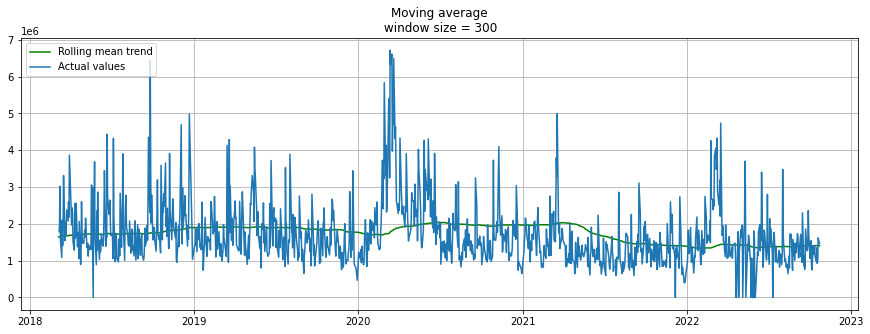

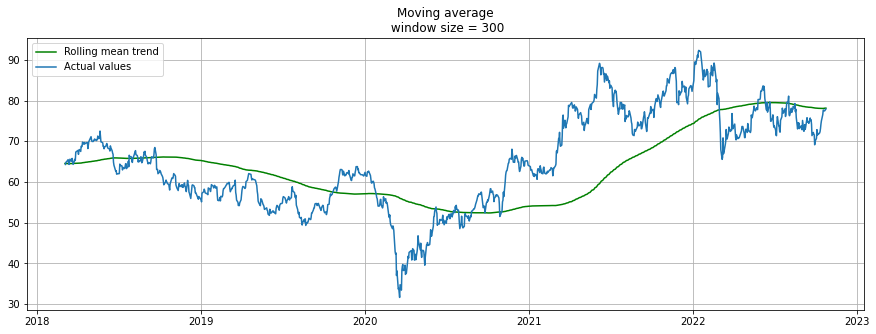

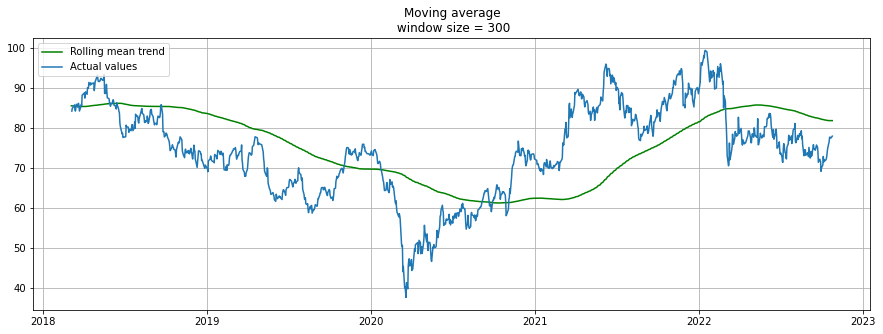

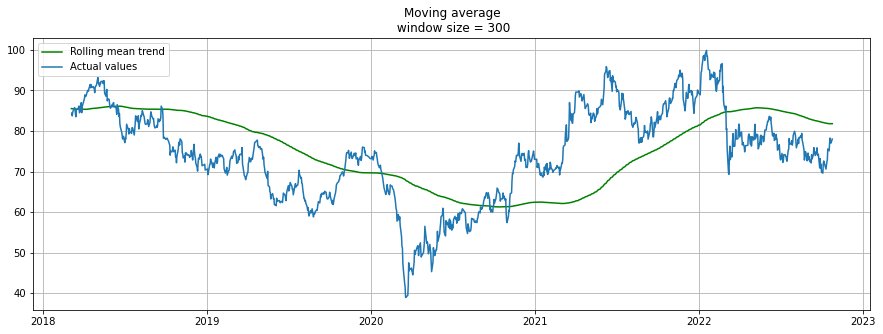

In [104]:
plotMovingAverage(df1['Volume'],300)
plotMovingAverage(df1['Adj Close'], 300)
plotMovingAverage(df1['Close'], 300)
plotMovingAverage(df1['Open'], 300)
# Во всех параметрах кроме Volume можно уловить тренд: сначала ниспадающий, потом возрастающий
# Проверим есть ли в наших данных сезонность проверив автокорелляцию 

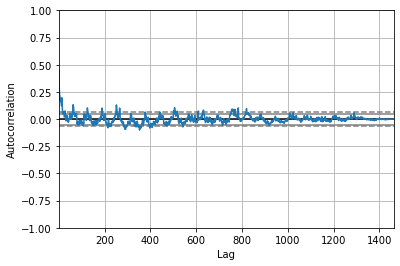

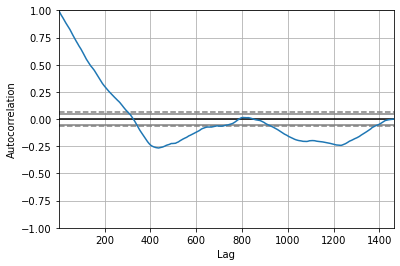

In [105]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df2['Volume'])
plt.show()
autocorrelation_plot(df2['Close'])
plt.show()
# Из графикоф можем сделать вывод, что в данных Volume нет сезонности, но она есть во всех остальных параметрах
# так как сезонность в данных есть, поищем ее с помощью декомпозиции нашего временного ряда

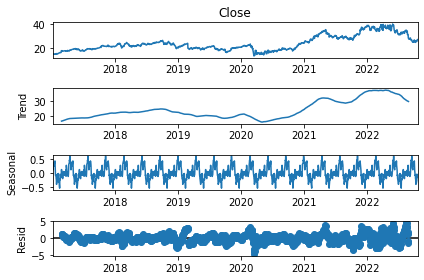

In [106]:
from statsmodels.tsa.seasonal import seasonal_decompose
df2_decomposed = seasonal_decompose(df2['Close'].dropna(),model='additive', period=6*12)
plot = df2_decomposed.plot()
    #Можно увидеть сезонность месячную сезонность во всех данных и восходящую линию тренда


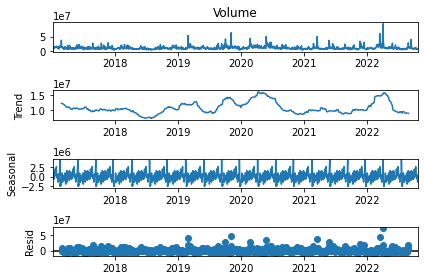

In [107]:
from statsmodels.tsa.seasonal import seasonal_decompose
df2_decomposed = seasonal_decompose(df2['Volume'].dropna(),model='additive', period=6*12)
plot = df2_decomposed.plot()
    #Можно увидеть сезонность месячную сезонность
